# Dataset statistics

In [1]:
from collections import defaultdict
import os

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Read graphs and clique sizes (.in, .out)

In [2]:
def load_networkx_graph_from_in(path):
    """Loads a networkx graph from a file in .in format."""
    def process_line_to_int_pair(line):
        line = line.strip().split()
        return int(line[0]) - 1, int(line[1]) - 1

    with open(path, "r") as f:
        lines = f.readlines()
        n, m = process_line_to_int_pair(lines[0])
        edges = [process_line_to_int_pair(line) for line in lines][1:]

    graph = nx.Graph()
    graph.add_nodes_from(range(1, n + 1))
    graph.add_edges_from(edges)
    return graph

In [3]:
DATA_DIR = os.path.join("..", "..", "data", "generated", "small_dimacs_bhoslib")
DATA_SETS = os.listdir(DATA_DIR)

graphs = defaultdict(list)
for data_set in DATA_SETS:
    data_set_dir = os.path.join(DATA_DIR, data_set)
    files = sorted(os.listdir(data_set_dir))
    
    graph_paths = [os.path.join(data_set_dir, file) 
                   for file in files if file.endswith(".in")]
    clique_paths = [os.path.join(data_set_dir, file) 
                    for file in files if file.endswith(".out")]
    assert(len(graph_paths) == len(clique_paths))
    
    for graph_path, clique_path in zip(graph_paths, clique_paths):
        graph = load_networkx_graph_from_in(graph_path)
        with open(clique_path, "r") as f:
            graph.clique_sizes = list(map(int, f.readlines()[0].strip().split()))
        graphs[data_set].append(graph)
        
print(graphs.keys())

dict_keys(['C.20.5', 'brock20', 'rb5-4', 'dsjc20', 'C.20.9'])


## Convert data to pandas dataframe

In [4]:
nodes_data = []
max_cliques_data = []
for data_set in DATA_SETS:
    for graph_id, graph in enumerate(graphs[data_set]):
        graph.degree_sequence = [id_degree[1] for id_degree in graph.degree()]
        mc = max(graph.clique_sizes)
        
        for node_id, deg_clq in enumerate(zip(graph.degree_sequence, graph.clique_sizes)):
            nodes_data.append([data_set, graph_id, node_id, *deg_clq, mc])
        mcc = np.sum(np.array(graph.clique_sizes) == mc)
        max_cliques_data.append([data_set, graph_id, mc, mcc])

nodes = pd.DataFrame(nodes_data,
    columns=["data_set", "graph_id", "node_id", "degree", "clique", "max_clique"])
max_cliques = pd.DataFrame(max_cliques_data,
    columns=["data_set", "graph_id", "max_clique", "max_clique_count"])

nodes.head()

,data_set,graph_id,node_id,degree,clique,max_clique
0,dsjc20,0,0,14,12,12
1,dsjc20,0,1,16,12,12
2,dsjc20,0,2,9,7,12
3,dsjc20,0,3,15,12,12
4,dsjc20,0,4,15,12,12


## How many vertices are in max. cliques?

In [5]:
nodes["in_mc"] = (nodes["clique"] == nodes["max_clique"])

node_counts = nodes.groupby(["data_set", "graph_id"]).count()
in_mc = nodes[nodes.in_mc == True].groupby(["data_set", "graph_id"]).count()
(in_mc / node_counts).groupby("data_set").mean()[["in_mc"]].sort_values("in_mc")

,in_mc
data_set,
C.20.5,0.5605
dsjc20,0.5815
brock20,0.6490
rb5-4,0.7325
C.20.9,0.7785


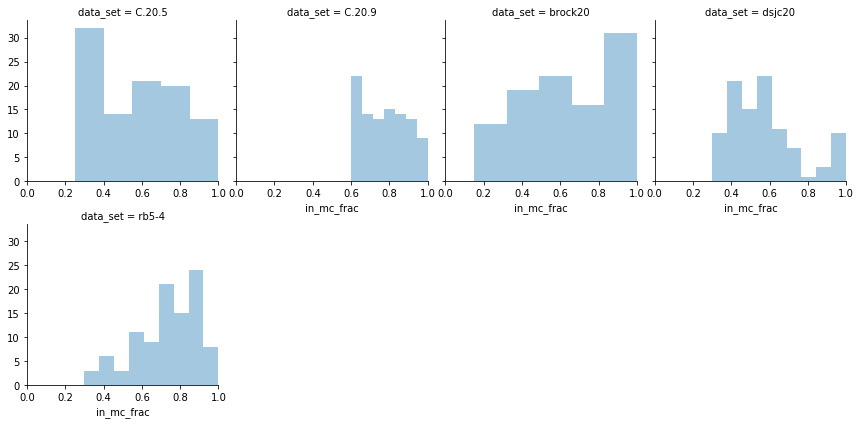

In [6]:
in_mc_df = pd.DataFrame(in_mc[["in_mc"]].to_records())
node_counts = nodes.groupby(["data_set", "graph_id"]).count()[["node_id"]]
node_counts_df = pd.DataFrame(node_counts.to_records())
index = ["data_set", "graph_id"]
in_mc_df = in_mc_df.set_index(index).join(node_counts_df.set_index(index))
in_mc_df["in_mc_frac"] = in_mc_df["in_mc"] / in_mc_df["node_id"]
in_mc_df = in_mc_df.reset_index()

grid = sns.FacetGrid(in_mc_df, col="data_set", col_wrap=4, sharex=False, height=3)
grid.map(sns.distplot, "in_mc_frac", kde=False)
for i in range(len(graphs.keys())):
    grid.axes[i].set_xlim(0,1)

## Clique size distributions

Text(0.5, 0.98, 'Max clique size distribution')

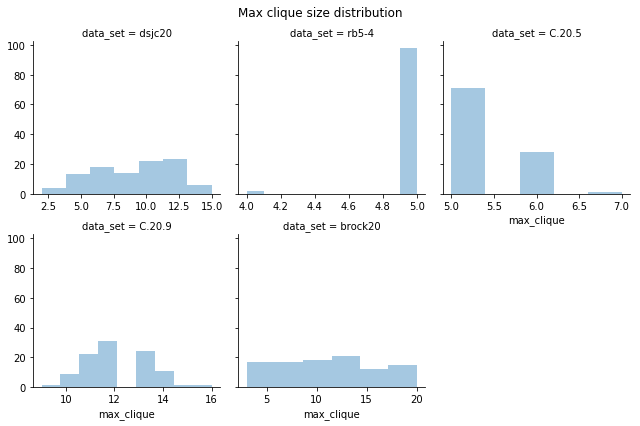

In [7]:
grid = sns.FacetGrid(max_cliques, col="data_set", col_wrap=3, sharex=False, height=3)
grid.map(sns.distplot, "max_clique", kde=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Max clique size distribution")

Text(0.5, 0.98, 'Clique size distribution')

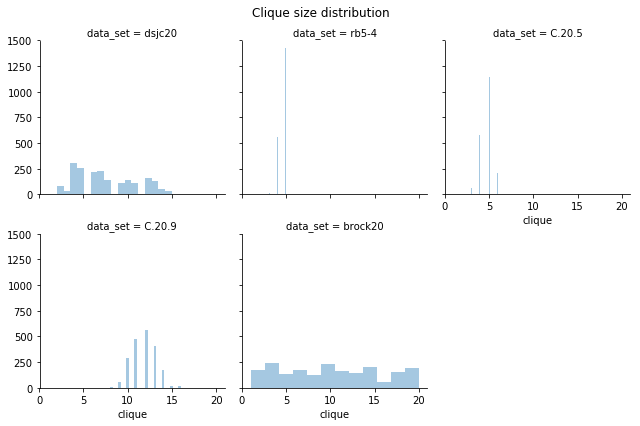

In [8]:
grid = sns.FacetGrid(nodes, col="data_set", col_wrap=3, sharex=True, height=3)
grid.map(sns.distplot, "clique", kde=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Clique size distribution")

Text(0.5, 0.98, 'Max clique size distribution')

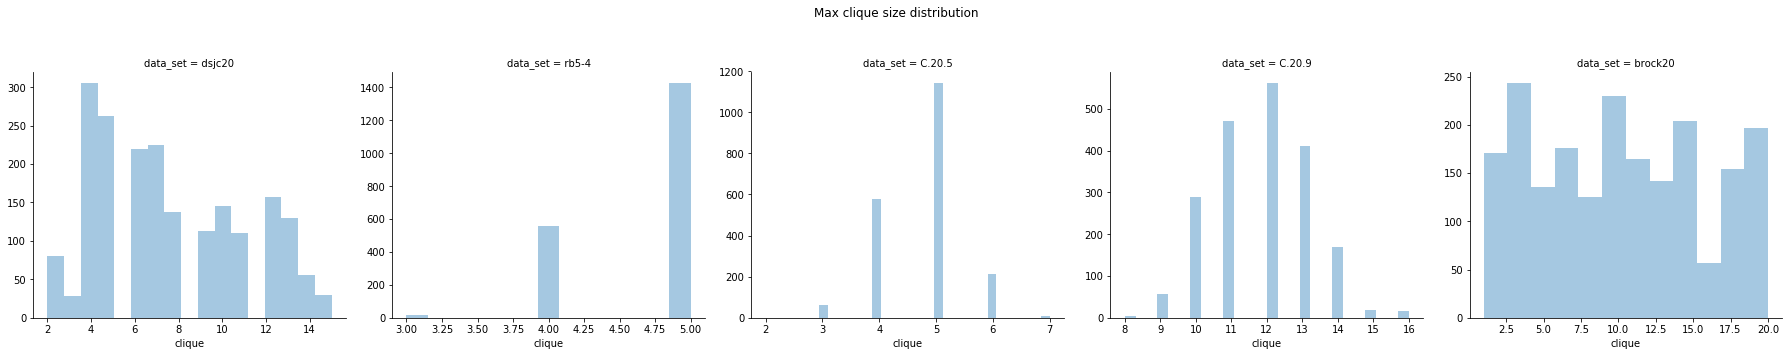

In [9]:
# uncomment to save plot
# sns.set(font_scale=1.5) 

grid = sns.FacetGrid(nodes[nodes.data_set != "hamm5"], col="data_set", sharex=False, sharey=False, height=5)
grid.map(sns.distplot, "clique", kde=False)
plt.subplots_adjust(top=0.8)
grid.fig.suptitle("Max clique size distribution")

# grid.savefig("clique_size_distribution.png")

In [10]:
nodes[nodes.data_set != "hamm5"].groupby("data_set").min()[["degree", "clique"]]

,degree,clique
data_set,,
C.20.5,3,2
C.20.9,11,8
brock20,0,1
dsjc20,2,2
rb5-4,5,3


In [11]:
nodes[nodes.data_set != "hamm5"].groupby("data_set").max()[["degree", "clique"]]

,degree,clique
data_set,,
C.20.5,17,7
C.20.9,19,16
brock20,19,20
dsjc20,19,15
rb5-4,16,5


## Relative clique sizes

In [12]:
nodes["rel_mc"] = nodes["clique"] / nodes["max_clique"]
nodes["rel_deg"] = nodes["clique"] / (nodes["degree"] + 1)

max_clique_nodes, all_nodes = (nodes["rel_mc"] == 1).sum(), len(nodes)
print('mc_nodes / all_nodes = {} / {} = {}'.format(
    max_clique_nodes, all_nodes, max_clique_nodes / all_nodes))

mc_nodes / all_nodes = 6604 / 10000 = 0.6604


Text(0.5, 0.98, 'rel_mc distribution')

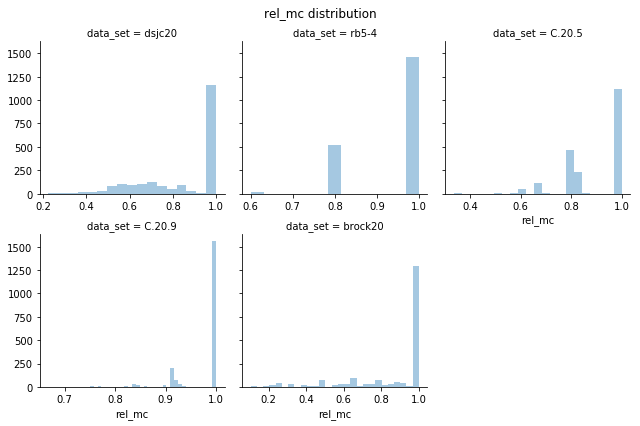

In [13]:
grid = sns.FacetGrid(nodes, col="data_set", col_wrap=3, sharex=False, height=3)
grid.map(sns.distplot, "rel_mc", kde=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("rel_mc distribution")

Text(0.5, 0.98, 'rel_deg distribution')

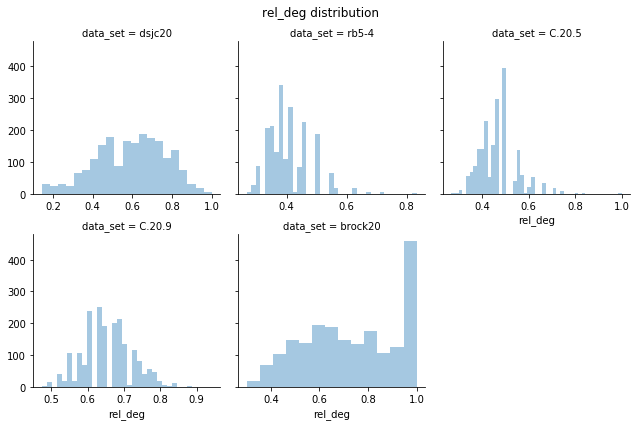

In [14]:
grid = sns.FacetGrid(nodes, col="data_set", col_wrap=3, sharex=False, height=3)
grid.map(sns.distplot, "rel_deg", kde=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("rel_deg distribution")

## Degree distributions

Text(0.5, 0.98, 'Degree distribution')

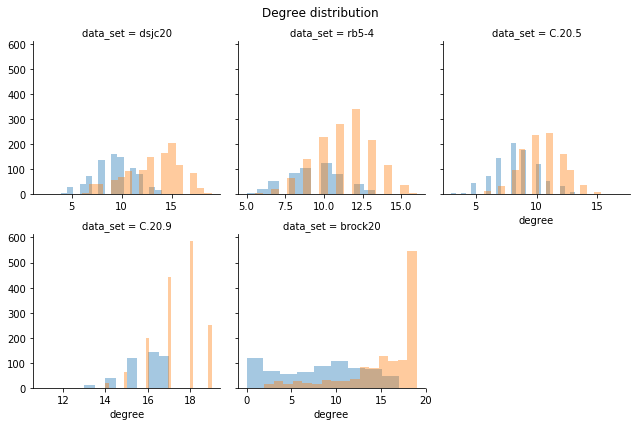

In [15]:
grid = sns.FacetGrid(nodes, col="data_set", hue="in_mc", col_wrap=3, sharex=False, height=3)
grid.map(sns.distplot, "degree", kde=False)
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Degree distribution")

## Stats table
Similar to one in http://iridia.ulb.ac.be/~fmascia/maximum_clique/DIMACS-benchmark

In [16]:
pivot_mean = nodes.groupby(["data_set"]).mean()[["degree", "clique"]]
pivot_q1 = nodes.groupby(["data_set"]).quantile(0.25)[["degree", "clique"]]
pivot_q3 = nodes.groupby(["data_set"]).quantile(0.75)[["degree", "clique"]]
pivot_iqr = pivot_q3 - pivot_q1
pivot_max = nodes.groupby(["data_set"]).max()[["degree", "clique"]]
pivot_max.columns = ["degree_max", "clique_max"]

nodes_cnt = nodes.groupby(["data_set", "graph_id"]).count()["node_id"]
edges_cnt = nodes.groupby(["data_set", "graph_id"]).sum()["degree"] / 2
density = edges_cnt / (nodes_cnt * (nodes_cnt - 1) / 2)
nodes_avg = pd.DataFrame(nodes_cnt.groupby(["data_set"]).mean())
nodes_avg.columns = ["avg_node_cnt"]
density_avg = pd.DataFrame(density.groupby(["data_set"]).mean())
density_avg.columns = ["avg_edge_density"]

pivot = pivot_mean.join(pivot_iqr, on="data_set",lsuffix="_avg", rsuffix="_iqr")
pivot = pivot.join(pivot_max, on="data_set", rsuffix="_max")
pivot = pivot.join(nodes_avg, on="data_set")
pivot = pivot.join(density_avg, on="data_set")

pivot.round(2)

,degree_avg,clique_avg,degree_iqr,clique_iqr,degree_max,clique_max,avg_node_cnt,avg_edge_density
data_set,,,,,,,,
C.20.5,9.53,4.76,3.0,1.0,17,7,20,0.50
C.20.9,17.07,11.81,2.0,2.0,19,16,20,0.90
brock20,12.71,10.18,9.0,10.0,19,20,20,0.67
dsjc20,11.56,7.63,5.0,5.0,19,15,20,0.61
rb5-4,10.81,4.70,3.0,1.0,16,5,20,0.57


## Degree-clique correlations

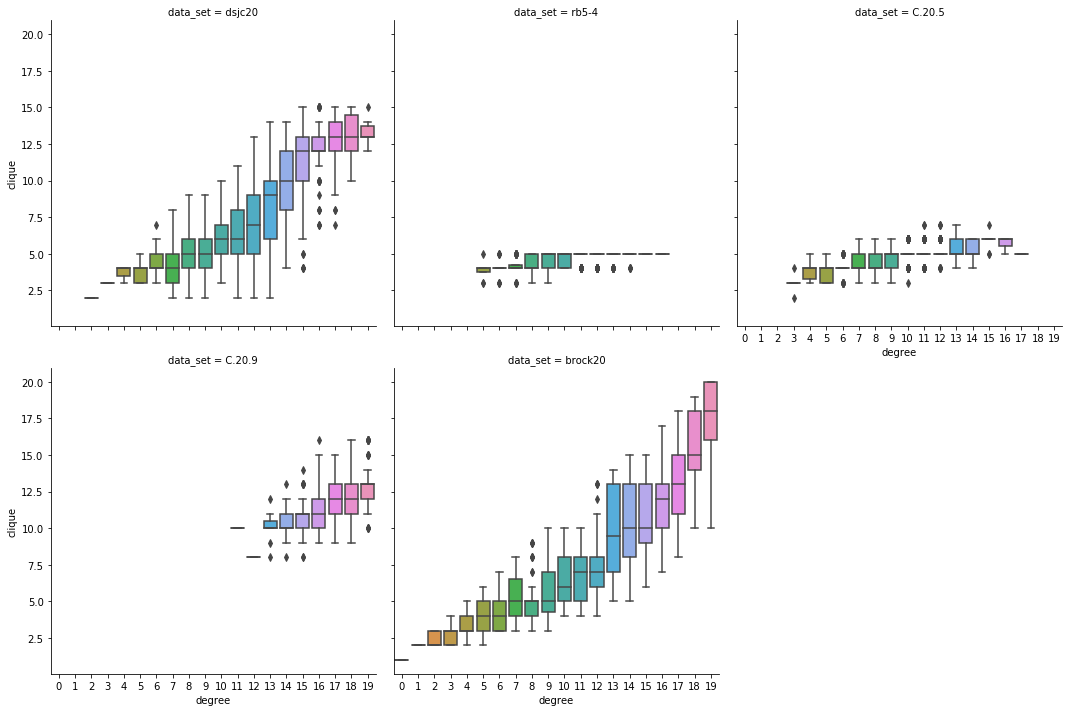

In [17]:
sns.catplot(x="degree", y="clique", data=nodes, 
            col="data_set", col_wrap=3, kind="box", sharex=True, sharey=True)

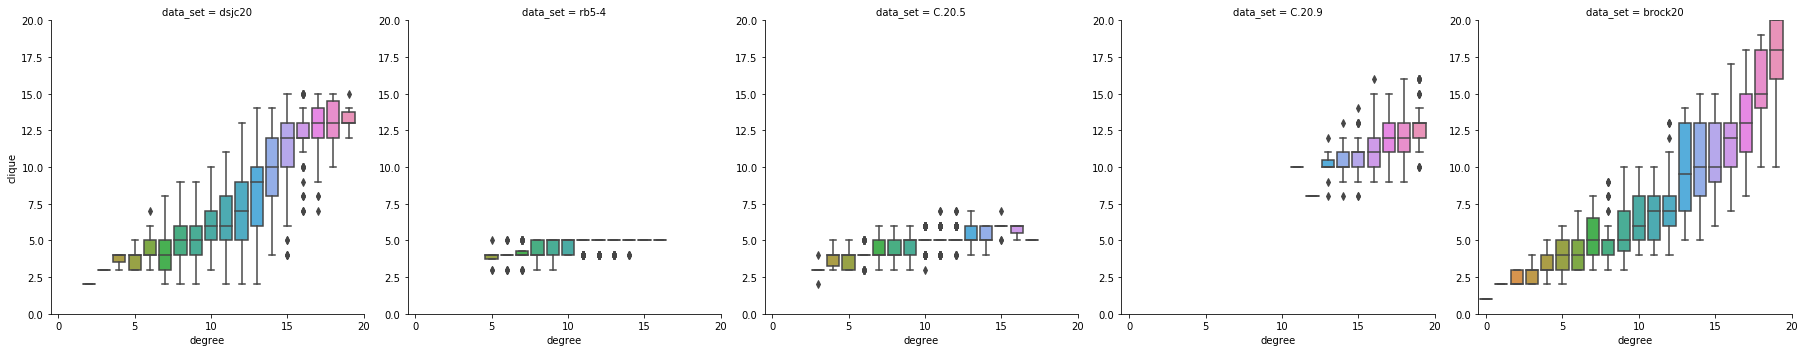

In [18]:
# uncomment to save plot
# sns.set(font_scale=2)
grid = sns.catplot(x="degree", y="clique", data=nodes[nodes.data_set != "hamm5"], 
            col="data_set", kind="box", sharex=True, sharey=False)

for ax in grid.axes[0]:
    ax.set_ylim(0,20)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticklabels([0, 5, 10, 15, 20])

# grid.savefig("clique_size_on_degree_distribution.png", dpi=300)

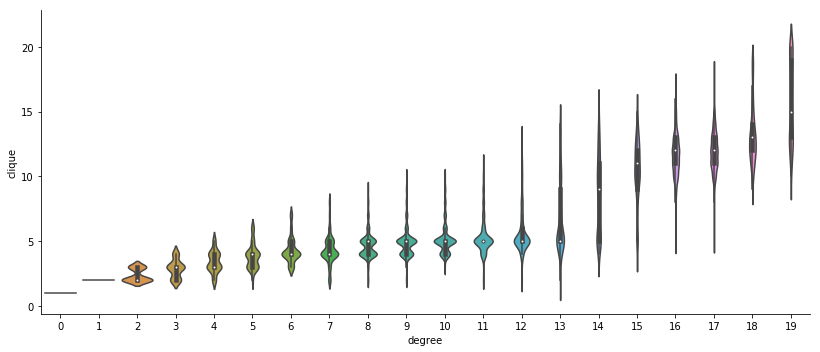

In [19]:
sns.catplot(x="degree", y="clique", data=nodes, kind="violin", aspect=2.3);

In [20]:
corr = nodes[["data_set", "degree", "clique"]].groupby(["data_set"]).corr().iloc[0::2,-1]
corr

data_set        
C.20.5    degree    0.596799
C.20.9    degree    0.474863
brock20   degree    0.890856
dsjc20    degree    0.780951
rb5-4     degree    0.435590
Name: clique, dtype: float64

## Display graphs

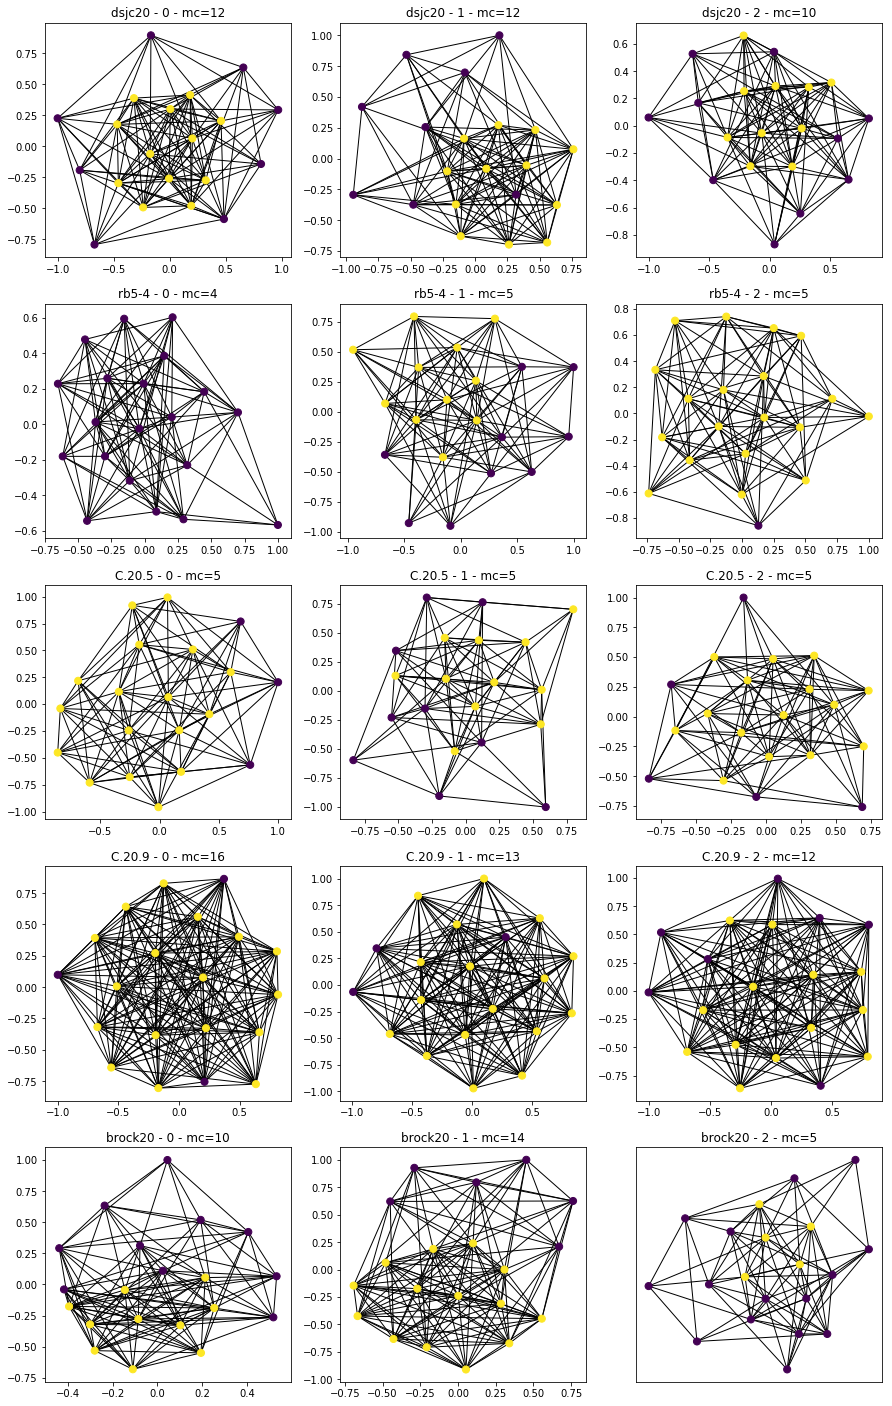

In [21]:
fig, ax = plt.subplots(len(DATA_SETS), 3, figsize=(15, 5 * len(DATA_SETS)))
for i, data_set in enumerate(DATA_SETS):
    for j in range(3):
        g = graphs[data_set][j]
        mc = max(g.clique_sizes)
        nx.draw_networkx(g, ax=ax[i, j], with_labels=False, node_size=50, pos=nx.spring_layout(g), 
                        node_color=np.array(g.clique_sizes) == mc)
        ax[i, j].set_title("{} - {} - mc={}".format(data_set, j, mc))